In [15]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

In [16]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [17]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0


In [18]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result
def slicing(dataset,index, i):
    return dataset.slice(index).kmer_index_encoding()[i]
def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result
def index_to_hotshot_encoding(index_encoded_peptide):
    result = np.zeros((len(index_encoded_peptide),21))
    for position, amino_acid in enumerate(index_encoded_peptide):
        result[position][amino_acid]= 1
    return result.flatten()
def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)


def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])


def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

In [19]:
def first_and_last_three(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:3],Y[-3+k:k]])
def first_and_last_four(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:4],Y[-4+k:k]])
def first_and_last_two(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:2],Y[-2+k:k]])
X_44 = np.apply_along_axis(index_to_hotshot_encoding,1,np.apply_along_axis(first_and_last_four,1,X))
X_33 = np.apply_along_axis(index_to_hotshot_encoding,1,np.apply_along_axis(first_and_last_three,1,X))
X_22 = np.apply_along_axis(index_to_hotshot_encoding,1,np.apply_along_axis(first_and_last_two,1,X))

In [20]:
folds = 3
n_epochs = 50
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

train_lr_aucs = np.zeros(folds)
test_lr_aucs = np.zeros(folds)
nine_train_lr_aucs = np.zeros(folds)
nine_test_lr_aucs = np.zeros(folds)
non_nine_train_lr_aucs = np.zeros(folds)
non_nine_test_lr_aucs = np.zeros(folds)

train_lr_22_aucs = np.zeros(folds)
test_lr_22_aucs = np.zeros(folds)
nine_train_lr_22_aucs = np.zeros(folds)
nine_test_lr_22_aucs = np.zeros(folds)
non_nine_train_lr_22_aucs = np.zeros(folds)
non_nine_test_lr_22_aucs = np.zeros(folds)

train_lr_33_aucs = np.zeros(folds)
test_lr_33_aucs = np.zeros(folds)
nine_train_lr_33_aucs = np.zeros(folds)
nine_test_lr_33_aucs = np.zeros(folds)
non_nine_train_lr_33_aucs = np.zeros(folds)
non_nine_test_lr_33_aucs = np.zeros(folds)

train_lr_44_aucs = np.zeros(folds)
test_lr_44_aucs = np.zeros(folds)
nine_train_lr_44_aucs = np.zeros(folds)
nine_test_lr_44_aucs = np.zeros(folds)
non_nine_train_lr_44_aucs = np.zeros(folds)
non_nine_test_lr_44_aucs = np.zeros(folds)

train_lr_f1= np.zeros(folds)
test_lr_f1= np.zeros(folds)
nine_train_lr_f1= np.zeros(folds)
nine_test_lr_f1= np.zeros(folds)
non_nine_train_lr_f1= np.zeros(folds)
non_nine_test_lr_f1= np.zeros(folds)

train_lr_22_f1= np.zeros(folds)
test_lr_22_f1= np.zeros(folds)
nine_train_lr_22_f1= np.zeros(folds)
nine_test_lr_22_f1= np.zeros(folds)
non_nine_train_lr_22_f1= np.zeros(folds)
non_nine_test_lr_22_f1= np.zeros(folds)

train_lr_33_f1= np.zeros(folds)
test_lr_33_f1= np.zeros(folds)
nine_train_lr_33_f1= np.zeros(folds)
nine_test_lr_33_f1= np.zeros(folds)
non_nine_train_lr_33_f1= np.zeros(folds)
non_nine_test_lr_33_f1= np.zeros(folds)

train_lr_44_f1= np.zeros(folds)
test_lr_44_f1= np.zeros(folds)
nine_train_lr_44_f1= np.zeros(folds)
nine_test_lr_44_f1= np.zeros(folds)
non_nine_train_lr_44_f1= np.zeros(folds)
non_nine_test_lr_44_f1= np.zeros(folds)

train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))


train_lstm_f1 = np.zeros((folds,n_epochs))
test_lstm_f1 = np.zeros((folds,n_epochs))
nine_train_lstm_f1 = np.zeros((folds,n_epochs))
nine_test_lstm_f1 = np.zeros((folds,n_epochs))
non_nine_train_lstm_f1 = np.zeros((folds,n_epochs))
non_nine_test_lstm_f1 = np.zeros((folds,n_epochs))



for i, (train_idx, test_idx) in enumerate(KFold(len(ds_h),folds, shuffle=True)):
    
    #indices
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    X_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_train )
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    X_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_train )
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    X_non_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_train )
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    X_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_test)
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    X_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_test)
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    X_non_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_test)
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
    
    
    lr = LinearRegression()
    lr_22 = LinearRegression()
    lr_33 = LinearRegression()
    lr_44 = LinearRegression()
    
    lr.fit(X_train_hotshot,y_train, sample_weight = weights_train)
    lr_22.fit(X_22[train_idx],y[train_idx])
    lr_33.fit(X_33[train_idx],y[train_idx])
    lr_44.fit(X_44[train_idx],y[train_idx])
    
    train_pred_lr = regroup_together(lr.predict(X_train_hotshot), weights_train, original_indices_train)
    test_pred_lr = regroup_together(lr.predict(X_test_hotshot), weights_test, original_indices_test)
    
    nine_train_pred_lr = regroup_together(lr.predict(X_nine_train_hotshot), weights_nine_train, original_indices_nine_train)
    nine_test_pred_lr = regroup_together(lr.predict(X_nine_test_hotshot), weights_nine_test, original_indices_nine_test)
    
    non_nine_train_pred_lr = regroup_together(lr.predict(X_non_nine_train_hotshot), weights_non_nine_train, original_indices_non_nine_train)
    non_nine_test_pred_lr = regroup_together(lr.predict(X_non_nine_test_hotshot), weights_non_nine_test, original_indices_non_nine_test)
    
    train_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_lr)     
    test_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_lr)
    nine_train_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_lr)     
    nine_test_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_lr)
    non_nine_train_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_lr)     
    non_nine_test_lr_aucs[i] = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_lr)
    
    train_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[train_idx],500), lr_22.predict(X_22[train_idx]))     
    test_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[test_idx],500), lr_22.predict(X_22[test_idx]))
    nine_train_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), lr_22.predict(X_22[nine_train_idx]))     
    nine_test_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), lr_22.predict(X_22[nine_test_idx]))
    non_nine_train_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), lr_22.predict(X_22[non_nine_train_idx]))     
    non_nine_test_lr_22_aucs[i] = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), lr_22.predict(X_22[non_nine_test_idx]))
    
    train_lr_33_aucs[i]=  roc_auc_score(measured_affinity_less_than(y[train_idx],500), lr_33.predict(X_33[train_idx]))     
    test_lr_33_aucs[i] = roc_auc_score(measured_affinity_less_than(y[test_idx],500), lr_33.predict(X_33[test_idx]))
    nine_train_lr_33_aucs[i]=  roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), lr_33.predict(X_33[nine_train_idx]))     
    nine_test_lr_33_aucs[i] = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), lr_33.predict(X_33[nine_test_idx]))
    non_nine_train_lr_33_aucs[i]=  roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), lr_33.predict(X_33[non_nine_train_idx]))     
    non_nine_test_lr_33_aucs[i] = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), lr_33.predict(X_33[non_nine_test_idx]))
    
    train_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[train_idx],500), lr_44.predict(X_44[train_idx]))     
    test_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[test_idx],500), lr_44.predict(X_44[test_idx]))
    nine_train_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), lr_44.predict(X_44[nine_train_idx]))     
    nine_test_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), lr_44.predict(X_44[nine_test_idx]))
    non_nine_train_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), lr_44.predict(X_44[non_nine_train_idx]))     
    non_nine_test_lr_44_aucs[i]= roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), lr_44.predict(X_44[non_nine_test_idx]))
    
    train_lr_f1[i] = f1_score(measured_affinity_less_than(train_real_labels,500),measured_affinity_less_than(train_pred_lr,500))
    test_lr_f1[i] = f1_score(measured_affinity_less_than(test_real_labels,500), measured_affinity_less_than(test_pred_lr,500))
    nine_train_lr_f1[i] = f1_score(measured_affinity_less_than(nine_train_real_labels,500),measured_affinity_less_than(nine_train_pred_lr,500))
    nine_test_lr_f1[i] = f1_score(measured_affinity_less_than(nine_test_real_labels,500), measured_affinity_less_than(nine_test_pred_lr,500))
    non_nine_train_lr_f1[i] = f1_score(measured_affinity_less_than(non_nine_train_real_labels,500),measured_affinity_less_than(non_nine_train_pred_lr,500))
    non_nine_test_lr_f1[i] = f1_score(measured_affinity_less_than(non_nine_test_real_labels,500), measured_affinity_less_than(non_nine_test_pred_lr,500))
    
    train_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[train_idx],500),measured_affinity_less_than(lr_22.predict(X_22[train_idx]),500))
    test_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[test_idx],500), measured_affinity_less_than(lr_22.predict(X_22[test_idx]),500))
    nine_train_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[nine_train_idx],500),measured_affinity_less_than(lr_22.predict(X_22[nine_train_idx]),500))
    nine_test_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[nine_test_idx],500), measured_affinity_less_than(lr_22.predict(X_22[nine_test_idx]),500))
    non_nine_train_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_train_idx],500),measured_affinity_less_than(lr_22.predict(X_22[non_nine_train_idx]),500))
    non_nine_test_lr_22_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_test_idx],500), measured_affinity_less_than(lr_22.predict(X_22[non_nine_test_idx]),500))
    
    train_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[train_idx],500),measured_affinity_less_than(lr_33.predict(X_33[train_idx]),500))
    test_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[test_idx],500), measured_affinity_less_than(lr_33.predict(X_33[test_idx]),500))
    nine_train_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[nine_train_idx],500),measured_affinity_less_than(lr_33.predict(X_33[nine_train_idx]),500))
    nine_test_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[nine_test_idx],500), measured_affinity_less_than(lr_33.predict(X_33[nine_test_idx]),500))
    non_nine_train_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_train_idx],500),measured_affinity_less_than(lr_33.predict(X_33[non_nine_train_idx]),500))
    non_nine_test_lr_33_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_test_idx],500), measured_affinity_less_than(lr_33.predict(X_33[non_nine_test_idx]),500))
    
    train_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[train_idx],500),measured_affinity_less_than(lr_44.predict(X_44[train_idx]),500))
    test_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[test_idx],500), measured_affinity_less_than(lr_44.predict(X_44[test_idx]),500))
    nine_train_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[nine_train_idx],500),measured_affinity_less_than(lr_44.predict(X_44[nine_train_idx]),500))
    nine_test_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[nine_test_idx],500), measured_affinity_less_than(lr_44.predict(X_44[nine_test_idx]),500))
    non_nine_train_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_train_idx],500),measured_affinity_less_than(lr_44.predict(X_44[non_nine_train_idx]),500))
    non_nine_test_lr_44_f1[i] = f1_score(measured_affinity_less_than(y[non_nine_test_idx],500), measured_affinity_less_than(lr_44.predict(X_44[non_nine_test_idx]),500))
    
    

    
    # normal LSTM
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr = 0.01)
    lstm.compile(optimizer = adam , loss='mean_squared_error')
    
    
    
    for epoch in range(n_epochs):
        print("epoch", epoch,"fold", i)
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500),lstm.predict(X[nine_train_idx]))
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500),lstm.predict(X[nine_test_idx]))
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500),lstm.predict(X[non_nine_train_idx]))
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500),lstm.predict(X[non_nine_test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc
        
        train_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[train_idx],500),measured_affinity_less_than(lstm.predict(X[train_idx]),500))
        test_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[test_idx],500), measured_affinity_less_than(lstm.predict(X[test_idx]),500))
        nine_train_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[nine_train_idx],500),measured_affinity_less_than(lstm.predict(X[nine_train_idx]),500))
        nine_test_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[nine_test_idx],500), measured_affinity_less_than(lstm.predict(X[nine_test_idx]),500))
        non_nine_train_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[non_nine_train_idx],500),measured_affinity_less_than(lstm.predict(X[non_nine_train_idx]),500))
        non_nine_test_lstm_f1[i][epoch] = f1_score(measured_affinity_less_than(y[non_nine_test_idx],500), measured_affinity_less_than(lstm.predict(X[non_nine_test_idx]),500))

epoch 0 fold 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0430    
epoch 1 fold 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0280    
epoch 2 fold 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0248    
epoch 3 fold 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0233    
epoch 4 fold 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0229    
epoch 5 fold 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0223    
epoch 6 fold 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0221    
epoch 7 fold 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0219    
epoch 8 fold 0
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0218    
epoch 9 fold 0
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0215     
epoch 10 fold 0
Epoch 1/1
6376/6376 [==============================] -

In [21]:
test_lr_44_aucs_mean = np.mean(test_lr_44_aucs, axis=0)
test_lr_33_aucs_mean = np.mean(test_lr_33_aucs, axis=0)
test_lr_22_aucs_mean = np.mean(test_lr_22_aucs, axis=0)
test_lr_aucs_mean = np.mean(test_lr_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

test_lr_44_f1_mean = np.mean(test_lr_44_f1, axis=0)
test_lr_33_f1_mean = np.mean(test_lr_33_f1, axis=0)
test_lr_22_f1_mean = np.mean(test_lr_22_f1, axis=0)
test_lr_f1_mean = np.mean(test_lr_f1, axis=0)
test_lstm_f1_mean = np.mean(test_lstm_f1, axis=0)

In [25]:
np.full(n_epochs, test_lr_44_aucs_mean)

array([ 0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066,
        0.94007066,  0.94007066,  0.94007066,  0.94007066,  0.94007066])

In [22]:
print(test_lr_aucs_mean, test_lr_44_aucs_mean, test_lr_33_aucs_mean, test_lr_22_aucs_mean)

0.943143747902 0.940070657535 0.9301802046 0.897164945373


In [23]:
print(test_lr_f1_mean, test_lr_44_f1_mean, test_lr_33_f1_mean, test_lr_22_f1_mean)

0.820123228547 0.816675958356 0.792619977087 0.738639177717


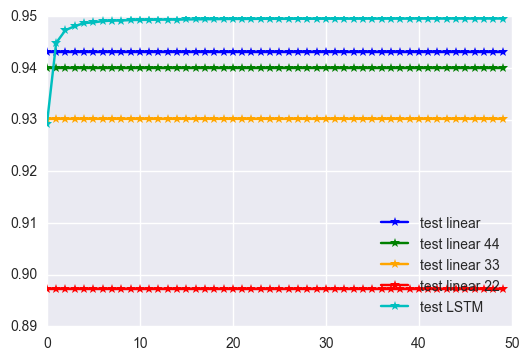

In [29]:
plt.plot( np.arange(0,50,1), np.full(n_epochs, test_lr_aucs_mean),color='b',marker='*', linestyle='-', label ="test linear")
plt.plot( np.arange(0,50,1), np.full(n_epochs, test_lr_44_aucs_mean),color='g',marker='*', linestyle='-', label ="test linear 44")
plt.plot( np.arange(0,50,1), np.full(n_epochs,test_lr_33_aucs_mean),color='orange',marker='*', linestyle='-', label ="test linear 33")
plt.plot( np.arange(0,50,1), np.full(n_epochs,test_lr_22_aucs_mean),color='r',marker='*', linestyle='-', label ="test linear 22")
plt.plot( np.arange(0,50,1), test_lstm_aucs_mean,color='c',marker='*', linestyle='-', label ="test LSTM")

plt.legend(loc=4)

In [30]:
nine_test_lr_44_aucs_mean = np.mean(nine_test_lr_44_aucs, axis=0)
nine_test_lr_33_aucs_mean = np.mean(nine_test_lr_33_aucs, axis=0)
nine_test_lr_22_aucs_mean = np.mean(nine_test_lr_22_aucs, axis=0)
nine_test_lr_aucs_mean = np.mean(nine_test_lr_aucs, axis=0)
nine_test_lstm_aucs_mean = np.mean(nine_test_lstm_aucs, axis=0)

nine_test_lr_44_f1_mean = np.mean(nine_test_lr_44_f1, axis=0)
nine_test_lr_33_f1_mean = np.mean(nine_test_lr_33_f1, axis=0)
nine_test_lr_22_f1_mean = np.mean(nine_test_lr_22_f1, axis=0)
nine_test_lr_f1_mean = np.mean(nine_test_lr_f1, axis=0)
nine_test_lstm_f1_mean = np.mean(nine_test_lstm_f1, axis=0)

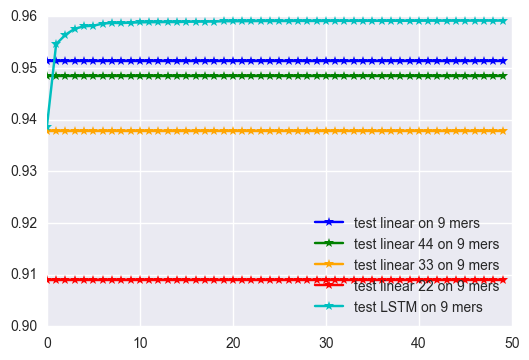

In [31]:
plt.plot( np.arange(0,50,1), np.full(n_epochs, nine_test_lr_aucs_mean),color='b',marker='*', linestyle='-', label ="test linear on 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs, nine_test_lr_44_aucs_mean),color='g',marker='*', linestyle='-', label ="test linear 44 on 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs,nine_test_lr_33_aucs_mean),color='orange',marker='*', linestyle='-', label ="test linear 33 on 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs,nine_test_lr_22_aucs_mean),color='r',marker='*', linestyle='-', label ="test linear 22 on 9 mers")
plt.plot( np.arange(0,50,1), nine_test_lstm_aucs_mean,color='c',marker='*', linestyle='-', label ="test LSTM on 9 mers")

plt.legend(loc=4)

In [32]:
non_nine_test_lr_44_aucs_mean = np.mean(non_nine_test_lr_44_aucs, axis=0)
non_nine_test_lr_33_aucs_mean = np.mean(non_nine_test_lr_33_aucs, axis=0)
non_nine_test_lr_22_aucs_mean = np.mean(non_nine_test_lr_22_aucs, axis=0)
non_nine_test_lr_aucs_mean = np.mean(non_nine_test_lr_aucs, axis=0)
non_nine_test_lstm_aucs_mean = np.mean(non_nine_test_lstm_aucs, axis=0)

non_nine_test_lr_44_f1_mean = np.mean(non_nine_test_lr_44_f1, axis=0)
non_nine_test_lr_33_f1_mean = np.mean(non_nine_test_lr_33_f1, axis=0)
non_nine_test_lr_22_f1_mean = np.mean(non_nine_test_lr_22_f1, axis=0)
non_nine_test_lr_f1_mean = np.mean(non_nine_test_lr_f1, axis=0)
non_nine_test_lstm_f1_mean = np.mean(non_nine_test_lstm_f1, axis=0)

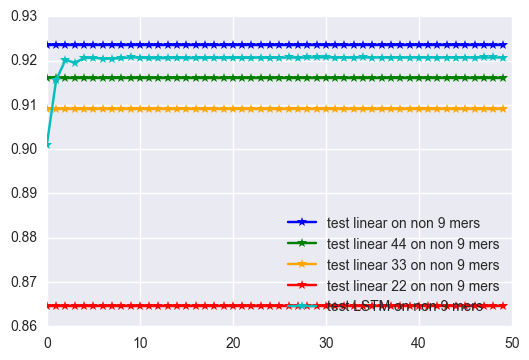

In [35]:
plt.plot( np.arange(0,50,1), np.full(n_epochs, non_nine_test_lr_aucs_mean),color='b',marker='*', linestyle='-', label ="test linear on non 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs, non_nine_test_lr_44_aucs_mean),color='g',marker='*', linestyle='-', label ="test linear 44 on non 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs,non_nine_test_lr_33_aucs_mean),color='orange',marker='*', linestyle='-', label ="test linear 33 on non 9 mers")
plt.plot( np.arange(0,50,1), np.full(n_epochs,non_nine_test_lr_22_aucs_mean),color='r',marker='*', linestyle='-', label ="test linear 22 on non 9 mers")
plt.plot( np.arange(0,50,1), non_nine_test_lstm_aucs_mean,color='c',marker='*', linestyle='-', label ="test LSTM on non 9 mers")

plt.legend(loc=4)